# Chest X-Ray Image classification

Link: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia  
Task: Classify images into NORMAL and PNEUMONIA tags  
Models tested: VGG19, VGG16 and InceptionResenetV2  
  
VGG19 accuracy: ~92%  
InceptionResentV2 accuracy: ~95.72%  

Following is the code for InceptionResnetV2

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


import os
import tensorflow as tf

# Check if GPU is detected
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
from tensorflow import keras
# Make sure tensorflow 2.0+ is running on the system
print("TensorFlow version is ", tf.__version__)

# Other required imports
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer
from random import shuffle
from sklearn.model_selection import GridSearchCV
import random
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import math
from pprint import pprint
import cv2

# Figure settings
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version is  2.2.0


## Division of data into train, test and validation

The data provided by Kaggle was not divided properly. In a different script I have divided and saved the images into 60% in train folder, 20% in test folder and remaining 20% in validate folder.  
Following is the directory structure:  
Divided_Data  
|\
|_ train  
&nbsp;&nbsp;&nbsp;&nbsp; |  
&nbsp;&nbsp;&nbsp;&nbsp; |_ PNEUMONIA  
&nbsp;&nbsp;&nbsp;&nbsp; |  
&nbsp;&nbsp;&nbsp;&nbsp; |_ NORMAL  
|\
|_ test  
&nbsp;&nbsp;&nbsp;&nbsp; |  
&nbsp;&nbsp;&nbsp;&nbsp; |_ PNEUMONIA  
&nbsp;&nbsp;&nbsp;&nbsp; |  
&nbsp;&nbsp;&nbsp;&nbsp; |_ NORMAL  
|\
|_ validate  
&nbsp;&nbsp;&nbsp;&nbsp; |  
&nbsp;&nbsp;&nbsp;&nbsp; |_ PNEUMONIA  
&nbsp;&nbsp;&nbsp;&nbsp; |  
&nbsp;&nbsp;&nbsp;&nbsp; |_ NORMAL  


 
We can also see that PNEUMONIA images are much more than normal images, this will be taken care during the training process.  

According to the description on Kaggle, "For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert"  
So we can assume that the images went through a thorough QC process and we don't need to go through it again.

In [2]:
base_dir = r'D:\Kaggle_Chest_XRay\Divided_Data'
# print(os.getcwd())
print(base_dir)

train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

print()

train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
print ('Total training PNEUMONIA images:', len(os.listdir(train_pneumonia_dir)))

train_normal_dir = os.path.join(train_dir, 'NORMAL')
print ('Total training NORMAL images:', len(os.listdir(train_normal_dir)))

print()

test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')
print ('Total testing PNEUMONIA images:', len(os.listdir(test_pneumonia_dir)))

test_normal_dir = os.path.join(test_dir, 'NORMAL')
print ('Total testing NORMAL images:', len(os.listdir(test_normal_dir)))

print()

validate_pneumonia_dir = os.path.join(validate_dir, 'PNEUMONIA')
print ('Total validate PNEUMONIA images:', len(os.listdir(validate_pneumonia_dir)))

validate_normal_dir = os.path.join(validate_dir, 'NORMAL')
print ('Total validate NORMAL images:', len(os.listdir(validate_normal_dir)))

D:\Kaggle_Chest_XRay\Divided_Data

Total training PNEUMONIA images: 2558
Total training NORMAL images: 955

Total testing PNEUMONIA images: 847
Total testing NORMAL images: 325

Total validate PNEUMONIA images: 868
Total validate NORMAL images: 303


## Form the data required for training

Form the required Train, Test and Validation data.
Following are the steps:
1. Read the image files, below I am using 'cv2'
2. Resize the image to 224, 224. This is because later we will be using Transfer Learning, most of the models require 224x224 images
3. Append the images into an array called X_train and labels in y_train. PNEUMONIA is represented as '1' and NORMAL is '0'
4. Randomize the images and make sure that the same randomizarion is applied to labels
5. Repeat the same steps for Test and Validation data

In [3]:
# Read data

# Train
X_train = []
y_train = []

train_pneumonia_list = os.listdir(train_pneumonia_dir)
for image_path in tqdm(train_pneumonia_list):
    img=cv2.imread(train_dir + '\\PNEUMONIA\\' + image_path)
    if img is not None:
        img_resize= cv2.resize(img,(224,224))
        data = np.asarray(img_resize, dtype="uint8")
        X_train.append(data)
        y_train.append(1)

train_normal_list = os.listdir(train_normal_dir)
for image_path in tqdm(train_normal_list):
    img=cv2.imread(train_dir + '\\NORMAL\\' + image_path)
    if img is not None:
        img_resize= cv2.resize(img,(224,224))
        data = np.asarray(img_resize, dtype="uint8")
        X_train.append(data)
        y_train.append(0)

combined = list(zip(X_train, y_train))

random.shuffle(combined)

X_train, y_train = zip(*combined)
X_train = np.array(X_train)/np.float32(255)
y_train = np.array(y_train)



# Test
X_test = []
y_test = []

test_pneumonia_list = os.listdir(test_pneumonia_dir)
for image_path in tqdm(test_pneumonia_list):
    img=cv2.imread(test_dir + '\\PNEUMONIA\\' + image_path)
    if img is not None:
        img_resize= cv2.resize(img,(224,224))
        data = np.asarray(img_resize, dtype="uint8")
        X_test.append(data)
        y_test.append(1)

test_normal_list = os.listdir(test_normal_dir)
for image_path in tqdm(test_normal_list):
    img=cv2.imread(test_dir + '\\NORMAL\\' + image_path)
    if img is not None:
        img_resize= cv2.resize(img,(224,224))
        data = np.asarray(img_resize, dtype="uint8")
        X_test.append(data)
        y_test.append(0)

combined = list(zip(X_test, y_test))

random.shuffle(combined)

X_test, y_test = zip(*combined)
X_test = np.array(X_test)/np.float32(255)
y_test = np.array(y_test)


# Validate
X_validate = []
y_validate = []

validate_pneumonia_list = os.listdir(validate_pneumonia_dir)
for image_path in tqdm(validate_pneumonia_list):
    img=cv2.imread(validate_dir + '\\PNEUMONIA\\' + image_path)
    if img is not None:
        img_resize= cv2.resize(img,(224,224))
        data = np.asarray(img_resize, dtype="uint8")
        X_validate.append(data)
        y_validate.append(1)

validate_normal_list = os.listdir(validate_normal_dir)
for image_path in tqdm(validate_normal_list):
    img=cv2.imread(validate_dir + '\\NORMAL\\' + image_path)
    if img is not None:
        img_resize= cv2.resize(img,(224,224))
        data = np.asarray(img_resize, dtype="uint8")
        X_validate.append(data)
        y_validate.append(0)

combined = list(zip(X_validate, y_validate))

random.shuffle(combined)

X_validate, y_validate = zip(*combined)
X_validate = np.array(X_validate)/np.float32(255)
y_validate = np.array(y_validate)

## Sample images

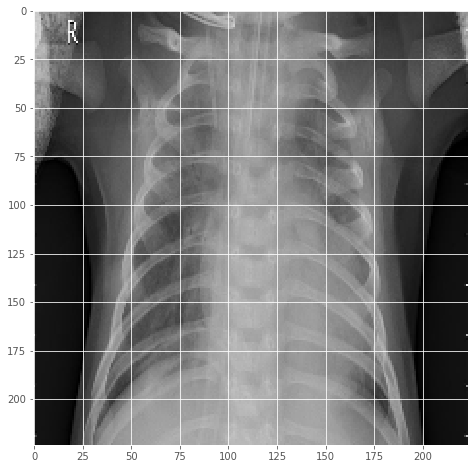

NORMAL


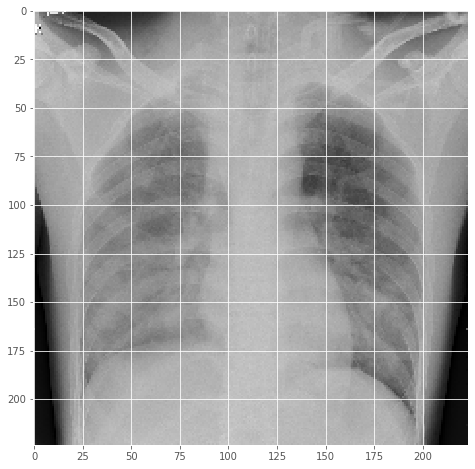

NORMAL


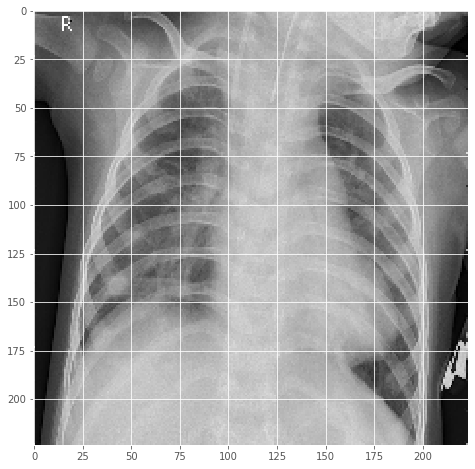

NORMAL


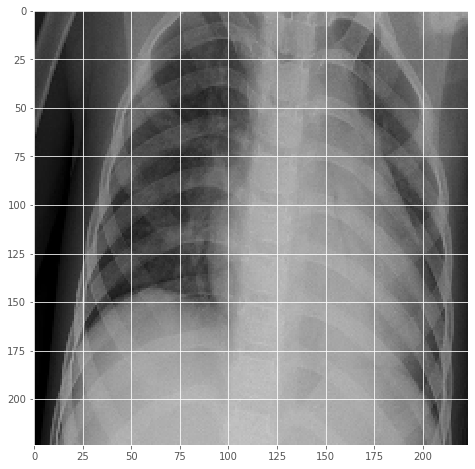

NORMAL


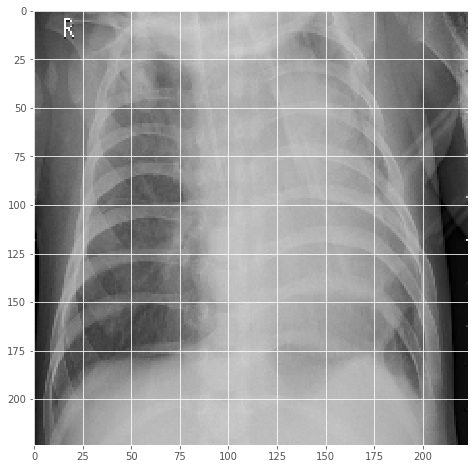

NORMAL


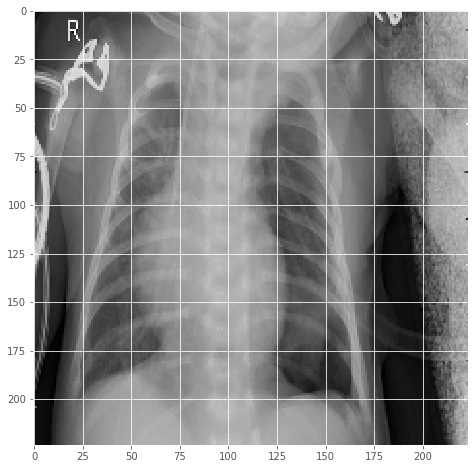

NORMAL


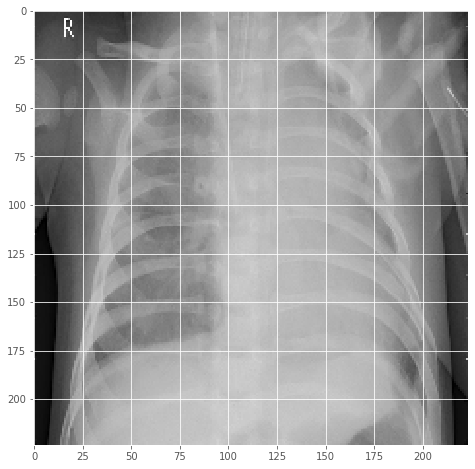

NORMAL


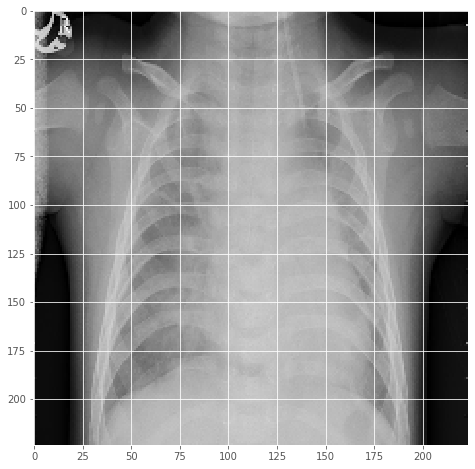

NORMAL


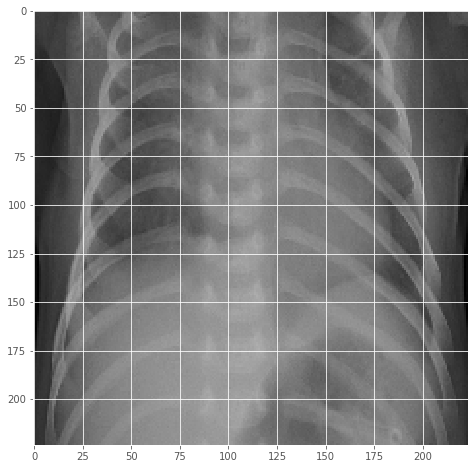

NORMAL


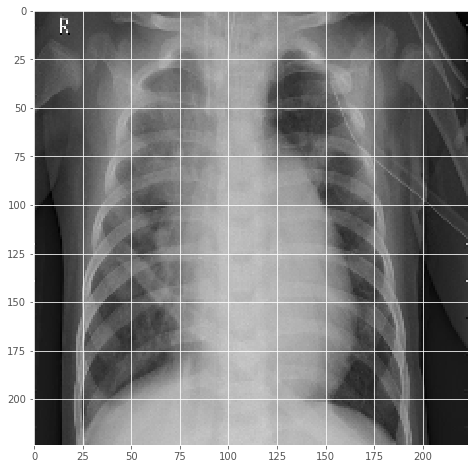

NORMAL


In [4]:
for i in range(10):
    plt.imshow(X_train[i], interpolation='nearest')
    plt.show()
    if y_train[i] == 0:
        print('PNEUMONIA')
    else:
        print('NORMAL')

In [6]:
parent_dir = r'D:\Kaggle_Chest_XRay\Models'
batch_size = 32
image_size = 224 # All images will be resized to 224*224
IMG_SHAPE = (image_size, image_size, 3) # Color Images with RGB (3) channels

## Performance of the model

This function will calculation all the required values to represent performance.  
Many times, accuracy is not a comprehensive indicator of performance on model, so we need some more indiicators.  
Some of them are:  

1. Precision = $\frac{TP}{TP+FP}$
2. Recall = $\frac{TP}{TP+FN}$
3. Accuracy = $\frac{TP+TF}{TP+TF+FP+FN}$
4. F1 = $\frac{2*Precision*Recall}{Precision+Recall}$ = $\frac{2*TP}{2*TP+FP+FN}$
5. False Alarm = $\frac{FP}{FP+TN}$
6. Catch Rate = $\frac{TP}{TP+FN}$

In [7]:
def calc_perf(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true=y_true,y_pred=y_pred)
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    output_dict = {}
    output_dict['precision'] = tp/(tp+fp)
    output_dict['recall'] = tp/(tp+fn)
    output_dict['f1-score'] = 2 * (output_dict['precision']*output_dict['recall']/
                                   (output_dict['precision']+output_dict['recall']))
    output_dict['false_alarm'] = fp/(fp+tn)
    output_dict['catch_rate'] = tp/(tp+fn)
    output_dict['accuracy'] = (tp+tn)/(tp+tn+fp+fn)
    return conf_matrix, output_dict

## Transfer learning

Using Tensorflow (or Keras or PyTorch) we can use pre-trained models and add a few layers on top to classify images to our needs.  
This is the basic definition of Transfer Learning in Image Classification.  

Here I am showing how to use Inception Resnet V2 model.  
Please follow the following link to get more information on which other models can be used:  
https://www.tensorflow.org/api_docs/python/tf/keras/applications

As seen below, I am building a few layers on top of base model.
I am also retraining all layers except first 5 layers.
There are 2 ways you can make this decision.
1. Go through the paper for selected Base model and see from which hidden layer you would retrain the weights
2. Automate the select the best possible setting

In [8]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation='sigmoid')
])

for layer in base_model.layers[:-5]:
    layer.trainable =  False

model.compile(tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               19661312  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 74,063,841
Trainable params: 23,857,441
Non-trainable params: 50,206,400
___________________________________

## Imbalanced data

As mentioned before, the image labels are imbalanced, so we need to feed class weights to the model during training.
This will help counter-act the imbalance.

In [10]:
COUNT_NORMAL = 955
TRAIN_IMG_COUNT = 955 + 2558
COUNT_PNEUMONIA = 2558

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

## Training the model

Here I am using the following callbacks:
1. ModelCheckpoint: Callback to save the Keras model or model weights at some frequency.
2. EarlyStopping: Stop training when a monitored metric has stopped improving
3. ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
4. CSVLogger: Callback that streams epoch results to a CSV file.


In [11]:
PATIENCE = 20
epochs = 100

checkpoint = tf.keras.callbacks.ModelCheckpoint(parent_dir + "\\Early_Stop_Fine_Tune_2.h5",
                                                monitor='val_accuracy', verbose=1, save_best_only=True, 
                                                mode='auto', save_freq='epoch')

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=PATIENCE, verbose=1, mode='auto')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                          patience=PATIENCE/2, min_lr=0.000001, verbose=1)
csv_logger = tf.keras.callbacks.CSVLogger(parent_dir + '\\training_fine_tune_2.log')


history_fine = model.fit(X_train,y_train, class_weight=class_weight,
                              validation_data=(X_validate, y_validate),
                              batch_size=batch_size,
                              epochs=epochs, verbose=1,
                              callbacks=[checkpoint, early, csv_logger, reduce_lr])

Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.8907
Epoch 00001: val_accuracy improved from -inf to 0.94535, saving model to D:\Kaggle_Chest_XRay\Models\Early_Stop_Fine_Tune_2.h5
110/110 [==============================] - 60s 547ms/step - loss: 0.3207 - accuracy: 0.8907 - val_loss: 0.1404 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9527
Epoch 00002: val_accuracy did not improve from 0.94535
110/110 [==============================] - 42s 385ms/step - loss: 0.1419 - accuracy: 0.9527 - val_loss: 0.1626 - val_accuracy: 0.9445 - lr: 1.0000e-04
Epoch 3/100
110/110 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9707
Epoch 00003: val_accuracy improved from 0.94535 to 0.95218, saving model to D:\Kaggle_Chest_XRay\Models\Early_Stop_Fine_Tune_2.h5
110/110 [==============================] - 56s 505ms/step - loss: 0.0956 - accuracy: 0.9707 - v

## Plotting the history of accuracy and loss on training and validation set

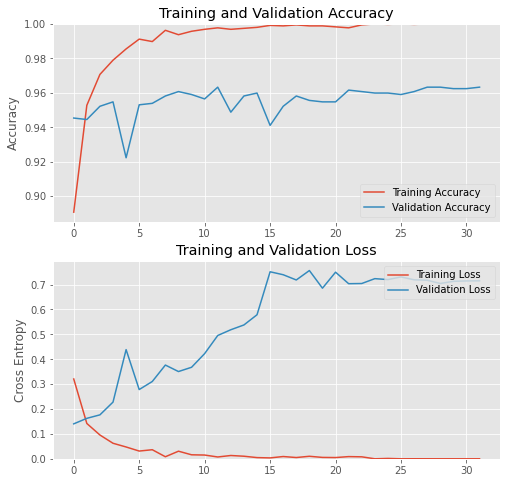

In [12]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Performance on Test dataset

In [13]:
# Test performance
test_pred = model.predict(X_test)
test_prediction = []
test_actual = []
for i in range(len(test_pred)):
    if test_pred[i][0] > 0.5:
        test_prediction.append(1)
    else:
        test_prediction.append(0)
    
for i in range(len(y_test)):
    test_actual.append(y_test[i])
    
confusion_m, perf = calc_perf(test_actual, test_prediction)
confusion_m

array([[303,  22],
       [ 15, 832]], dtype=int64)

In [14]:
perf

{'precision': 0.9742388758782201,
 'recall': 0.9822904368358913,
 'f1-score': 0.9782480893592005,
 'false_alarm': 0.06769230769230769,
 'catch_rate': 0.9822904368358913,
 'accuracy': 0.9684300341296929,
 'Ratio_CR_FA': 14.511108725984759}

In [15]:
label_map = {0:"Normal", 1:"Pneumonia"}

## Misclassified images in test dataset

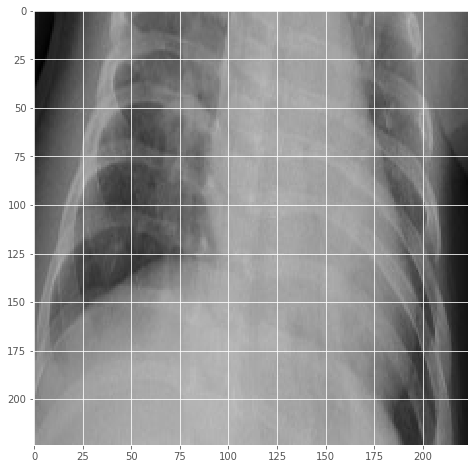

Normal predicted as Pneumonia


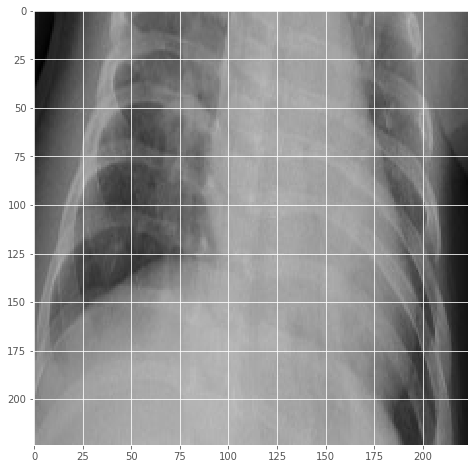

Normal predicted as Pneumonia


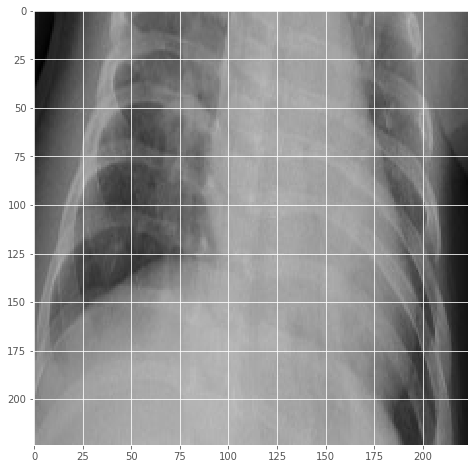

Normal predicted as Pneumonia


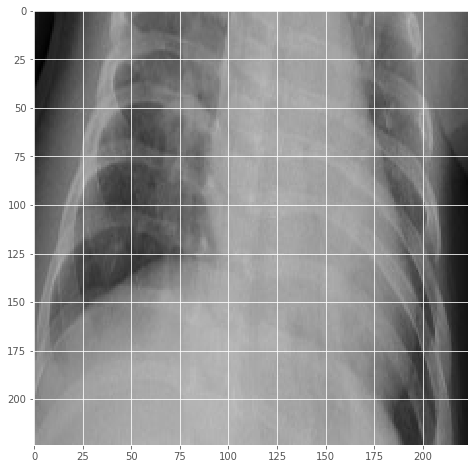

Pneumonia predicted as Normal


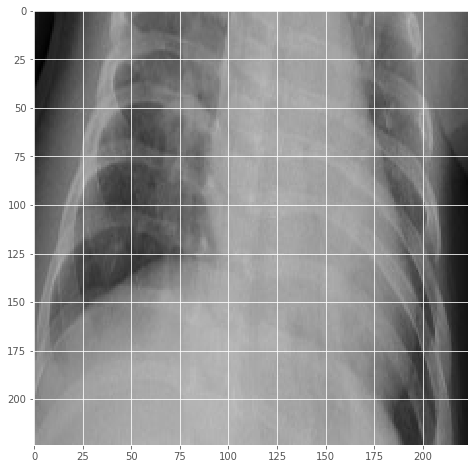

Pneumonia predicted as Normal


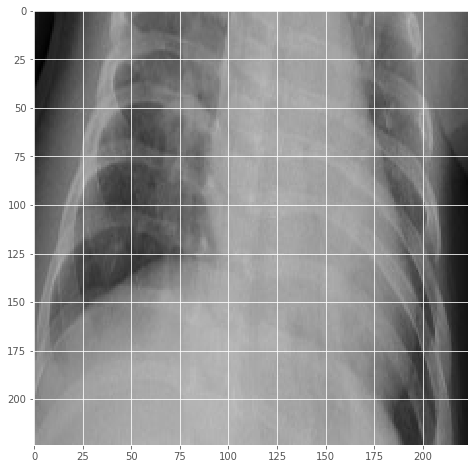

Pneumonia predicted as Normal


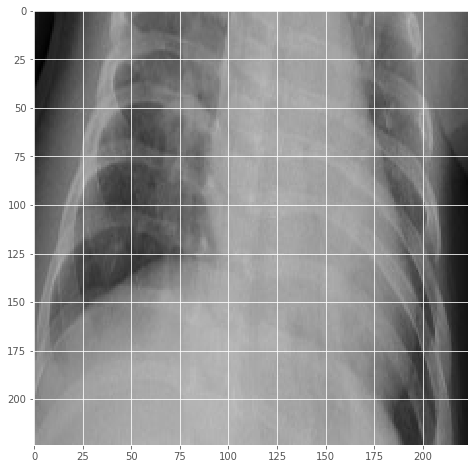

Pneumonia predicted as Normal


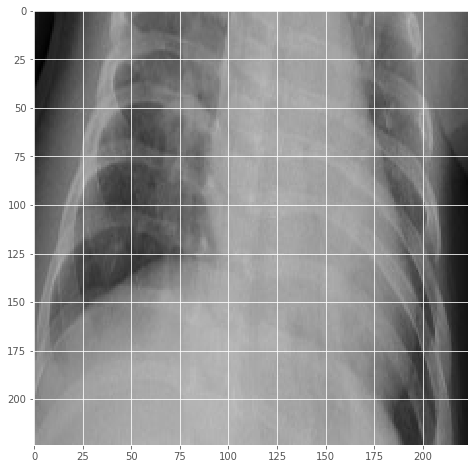

Normal predicted as Pneumonia


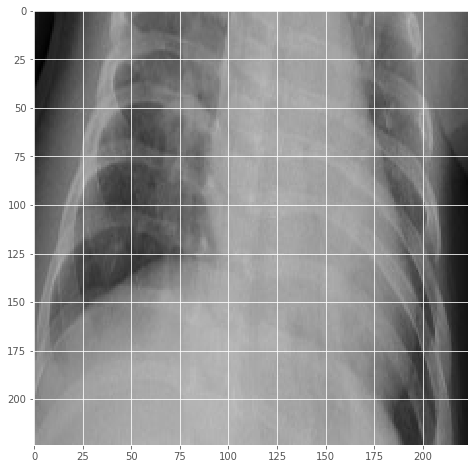

Pneumonia predicted as Normal


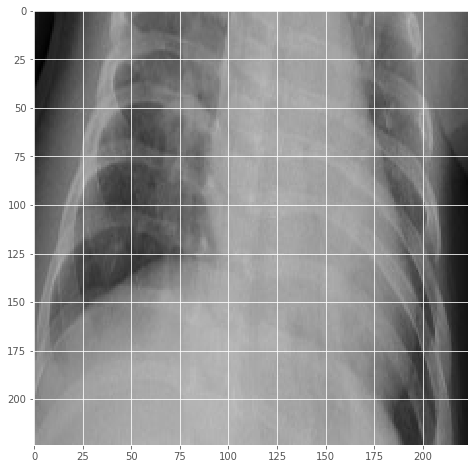

Normal predicted as Pneumonia


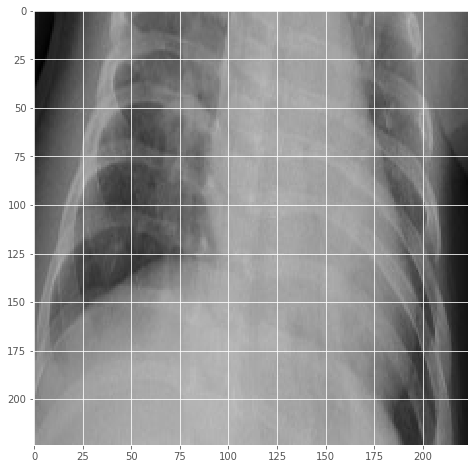

Pneumonia predicted as Normal


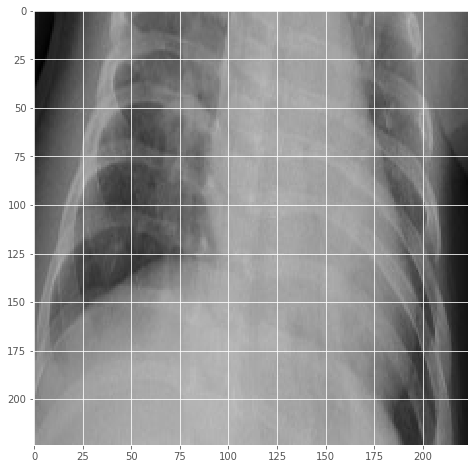

Pneumonia predicted as Normal


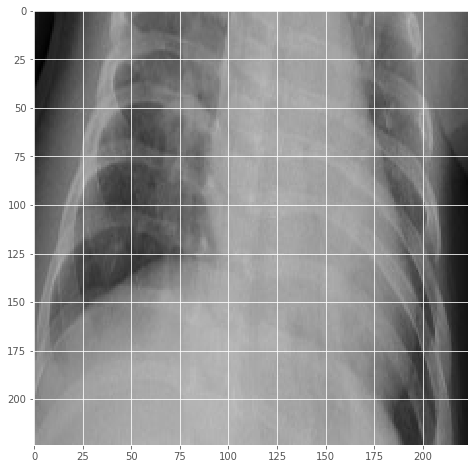

Normal predicted as Pneumonia


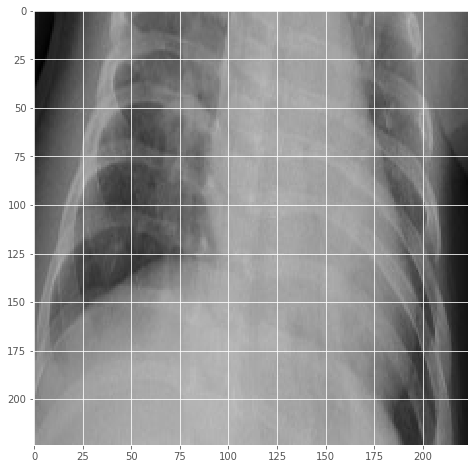

Pneumonia predicted as Normal


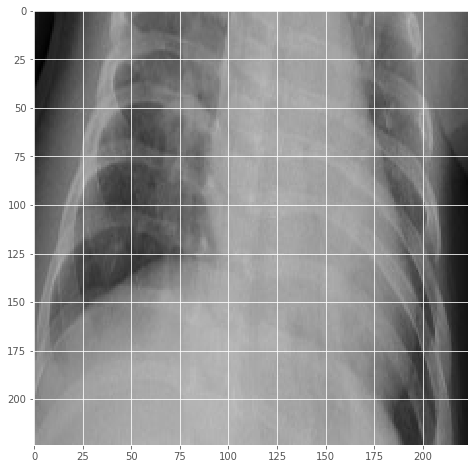

Pneumonia predicted as Normal


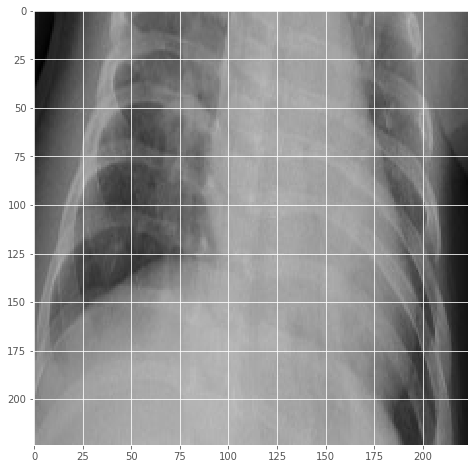

Normal predicted as Pneumonia


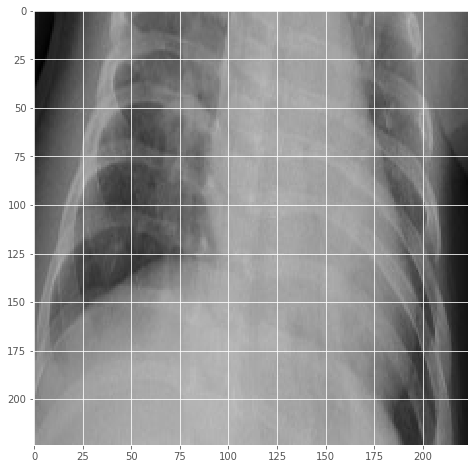

Normal predicted as Pneumonia


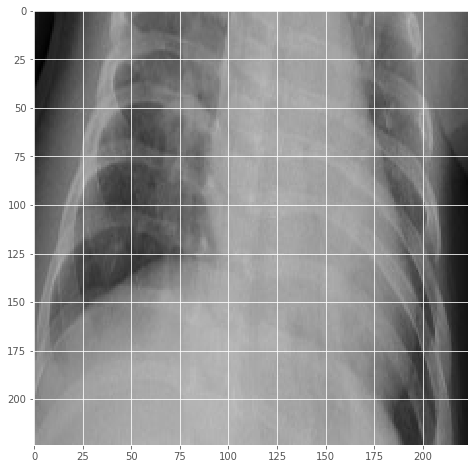

Normal predicted as Pneumonia


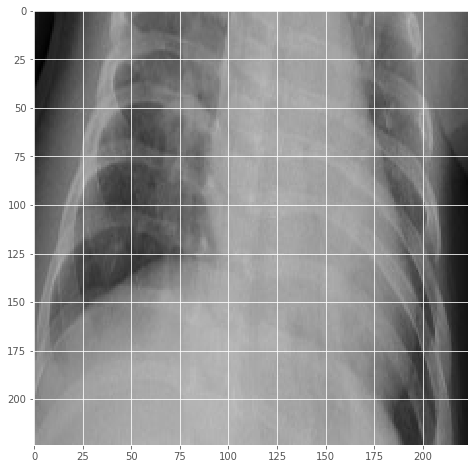

Pneumonia predicted as Normal


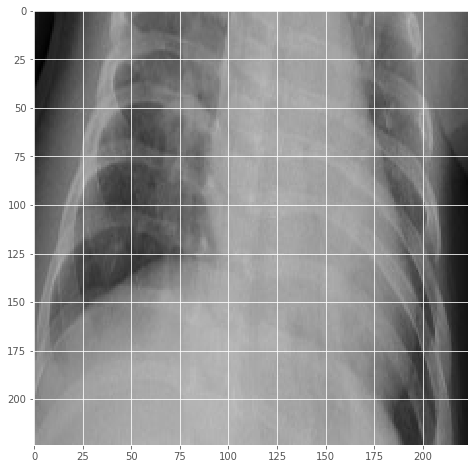

Pneumonia predicted as Normal


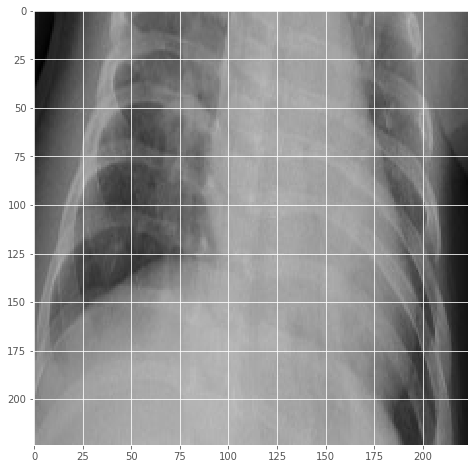

Normal predicted as Pneumonia


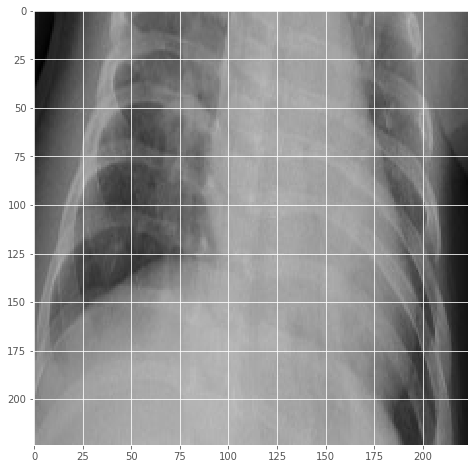

Normal predicted as Pneumonia


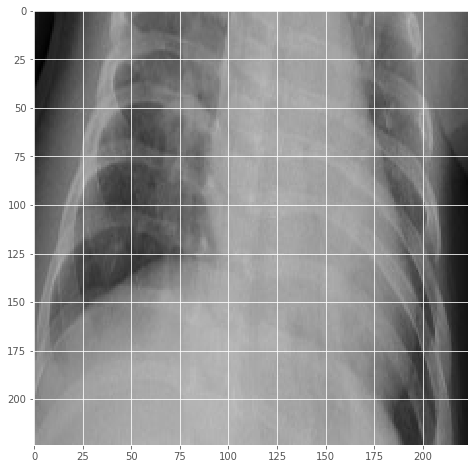

Pneumonia predicted as Normal


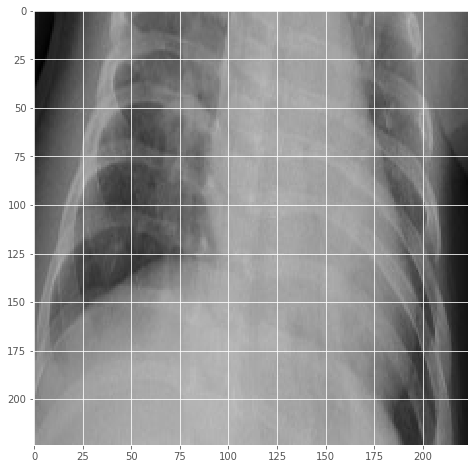

Normal predicted as Pneumonia


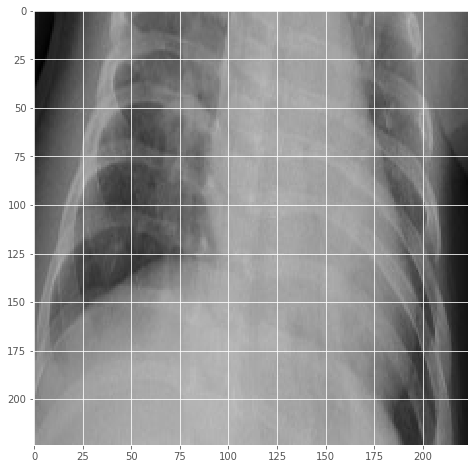

Pneumonia predicted as Normal


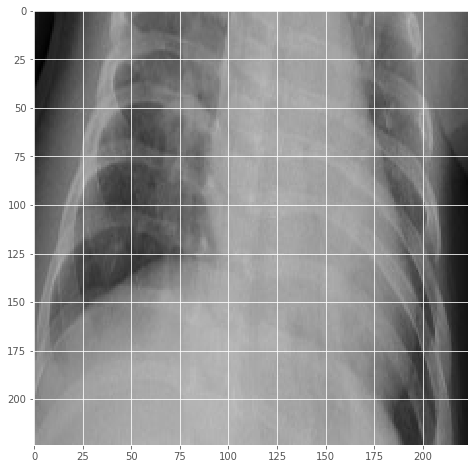

Normal predicted as Pneumonia


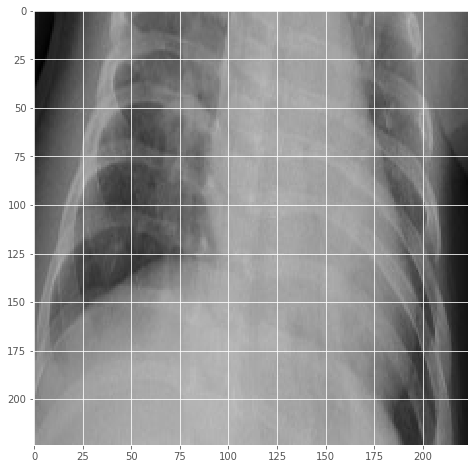

Normal predicted as Pneumonia


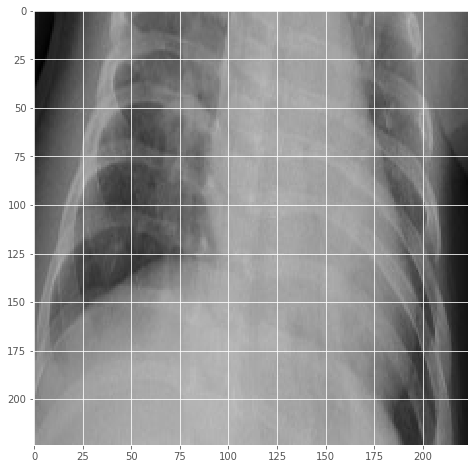

Normal predicted as Pneumonia


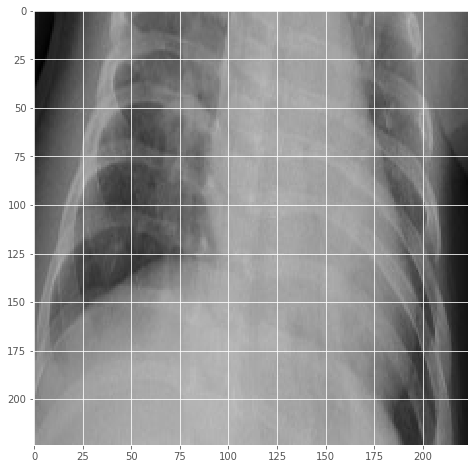

Pneumonia predicted as Normal


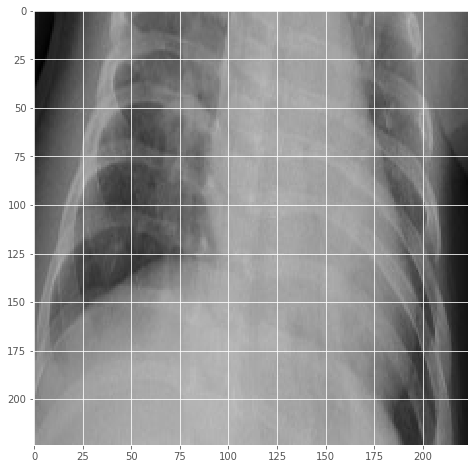

Normal predicted as Pneumonia


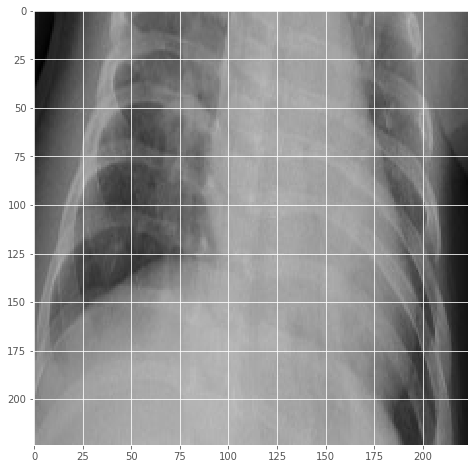

Normal predicted as Pneumonia


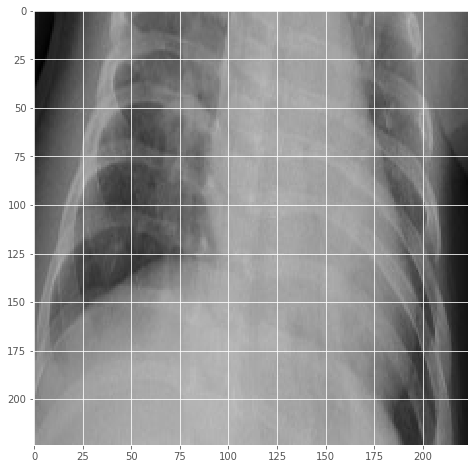

Pneumonia predicted as Normal


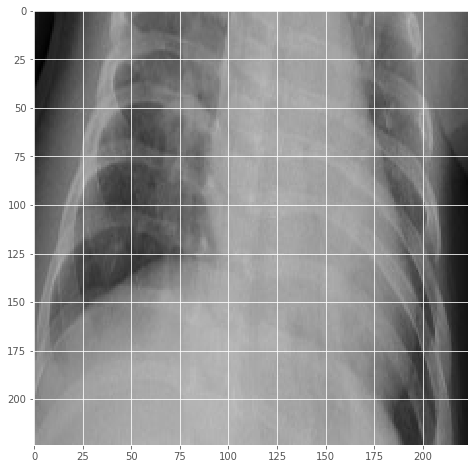

Normal predicted as Pneumonia


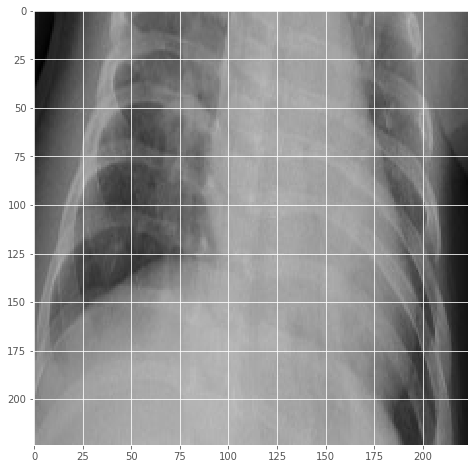

Normal predicted as Pneumonia


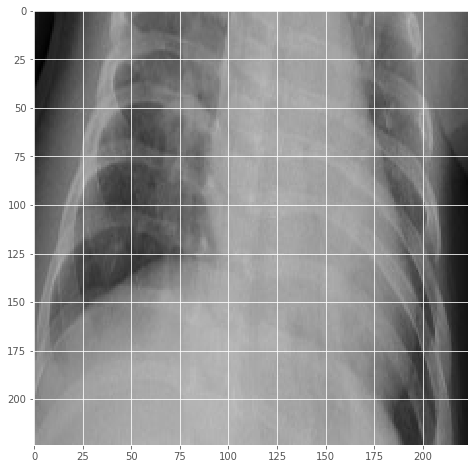

Normal predicted as Pneumonia


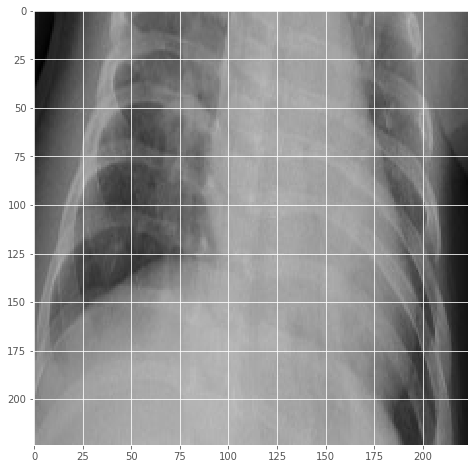

Normal predicted as Pneumonia


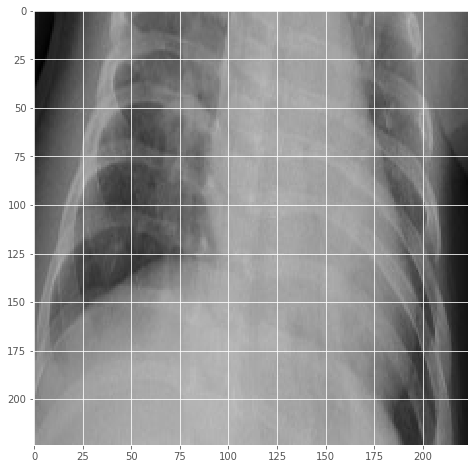

Normal predicted as Pneumonia


In [16]:
for index, pred in enumerate(test_prediction):
    if pred != y_test[index]:
        plt.imshow(X_test[i], interpolation='nearest')
        plt.show()
        print('{} predicted as {}'.format(label_map[y_test[index]], label_map[pred]))

## Accuracy on test dataset

In [17]:
all_acc = []
for index, array in enumerate(confusion_m):
    all_acc.append(array[index]/(sum(array)))

print(sum(all_acc)/len(all_acc))

0.9572990645717918
